In [3]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, STOPWORDS
import nltk
nltk.download("wordnet")

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

import crear_modelo_config

class Topic:
    pass

if __name__ == "__main__":
    ml_dataset = pd.read_csv("TweetsTrainDev.csv")
    ml_dataset.drop(ml_dataset[ml_dataset["airline"] != "United"].index, inplace = True)
    ml_dataset.drop(ml_dataset[ml_dataset["airline_sentiment"] != "negative"].index, inplace = True)

    docs = list(ml_dataset["text"])
    negative_reasons = list(ml_dataset["negativereason"])[:]
    original_docs = docs[:]
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')

    stopwords = STOPWORDS.union(frozenset(["ua", "we", "on", "me", "you"])).difference(["kg", "before", "over", "system", "serious", "off", "take", "nowhere", "found"])
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = remove_stopwords(docs[idx], STOPWORDS)
        docs[idx] = strip_punctuation(docs[idx])
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words."""

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.1)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # Set training parameters.
    num_topics = 12
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    var_start = 100
    var_end = 1000
    var_step = 50
    models = []
    topics = []
    for _ in range(0, num_topics):
        topics.append([])
    differences = []
    for _ in range(0, num_topics):
        differences.append([])
    for iterations in range(var_start, var_end, var_step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha=0.0001, # type: ignore
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every # type: ignore
        )
        models.append(model)
        top_topics = model.top_topics(corpus)

        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
        print('Average topic coherence: %.4f.' % avg_topic_coherence)

        from pprint import pprint
        #pprint(top_topics)
        """for index, i in enumerate(top_topics):
            pprint(model.show_topic(index))"""

        for i in range(0, num_topics):
            topics[i].append(Topic())

        for (index, topic) in enumerate(top_topics):
            topics[index][-1].topic = topic

        topic_twits = []
        reasons = []
        for i in range(0, num_topics):
            topic_twits.append([])
            reasons.append({})

        for (index, twit) in enumerate(corpus):
            for (i, score_in_topic) in model.get_document_topics(twit):
                topic_twits[i].append((score_in_topic, original_docs[index])) # type: ignore
                negative_reason = negative_reasons[index]
                if negative_reason in reasons[i]: # type: ignore
                    reasons[i][negative_reason] += score_in_topic # type: ignore
                else:
                    #negative_reason no estaba registrado
                    reasons[i][negative_reason] = score_in_topic # type: ignore

        for (index, twits) in enumerate(topic_twits):
            #print(f"topic {index}:")
            twits.sort(key=lambda x: x[0], reverse=True)
            topics[index][-1].twits = twits[0:5]
            """for twit in twits[0:5]:
                print(twit)"""

            """print()
            print()"""

        for (index, topic) in enumerate(reasons):
            reason_list = list(topic.items())
            reason_list.sort(key=lambda x: x[1], reverse=True)
            topics[index][-1].reasons = reason_list
            #print(f"topic {index}")
            """for reason in reason_list:
                print(reason)

            print()
            print()"""

        for (index, topic) in enumerate(topics):
            topic = topic[-1]
            #print(f"topic {index}")
            #pprint(topic.topic)
            #pprint(topic.twits)
            top_reasons = topic.reasons[0:3]
            max_reason_score = top_reasons[0][1]
            difference = max_reason_score-top_reasons[1][1]-top_reasons[2][1]

            differences[index].append(difference)
    


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Number of unique tokens: 245
Number of documents: 2633
Average topic coherence: -8.8645.
Average topic coherence: -8.1087.
Average topic coherence: -8.4747.
Average topic coherence: -8.6994.
Average topic coherence: -8.5445.
Average topic coherence: -8.7011.
Average topic coherence: -8.5530.
Average topic coherence: -8.9261.
Average topic coherence: -9.0565.
Average topic coherence: -8.5704.
Average topic coherence: -8.2745.
Average topic coherence: -8.3963.
Average topic coherence: -7.6982.
Average topic coherence: -8.6552.
Average topic coherence: -8.5245.
Average topic coherence: -8.5430.
Average topic coherence: -8.7991.
Average topic coherence: -8.2713.


In [4]:

diif_scores = []
var_arr = []

var = var_start
for model in models:
        var_arr.append(var)
        var += var_step

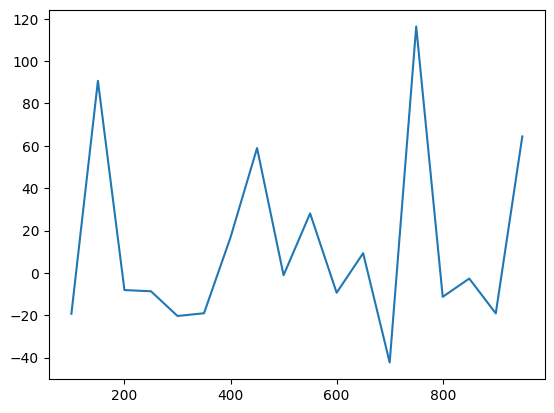

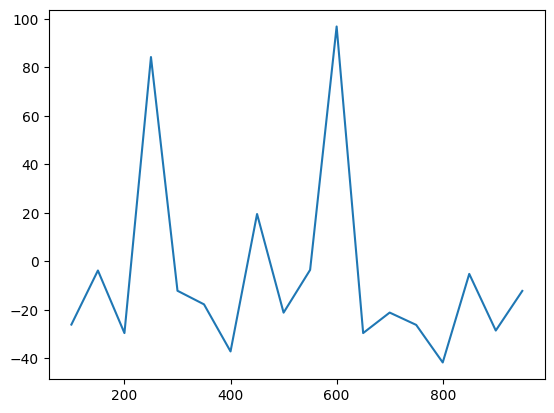

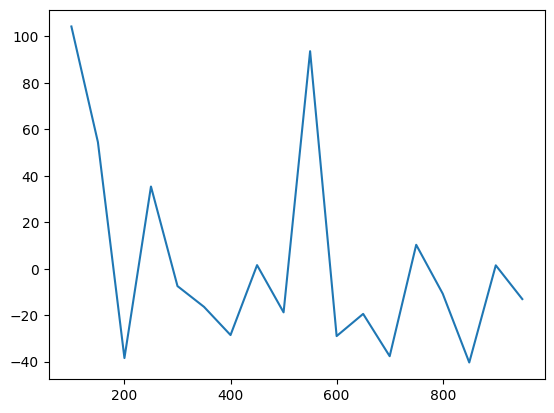

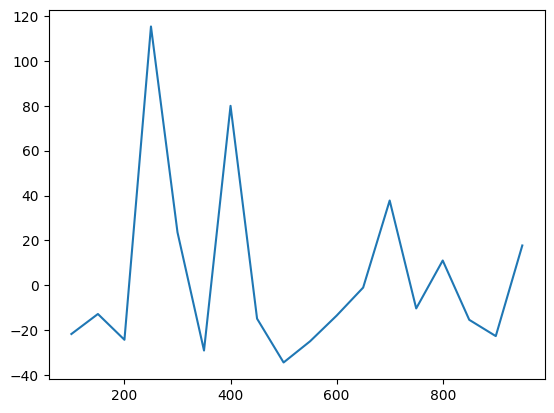

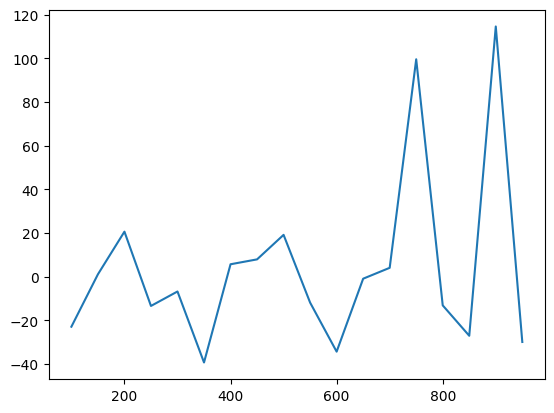

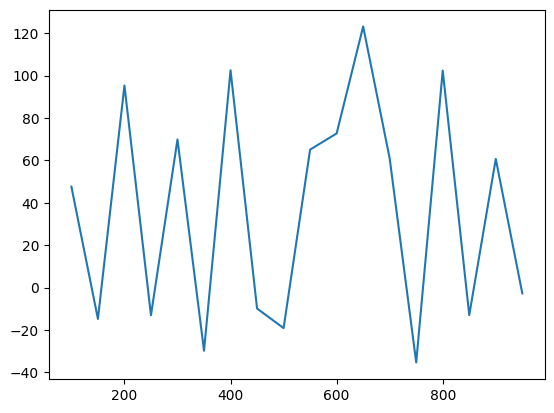

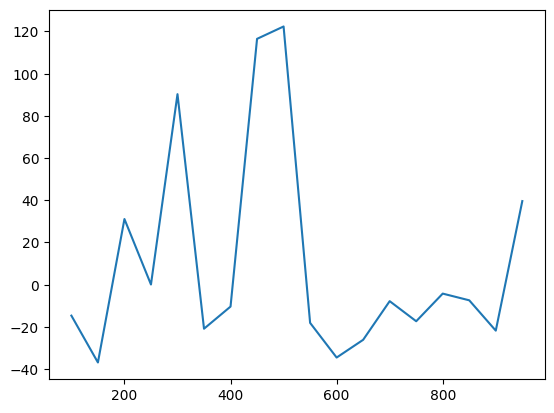

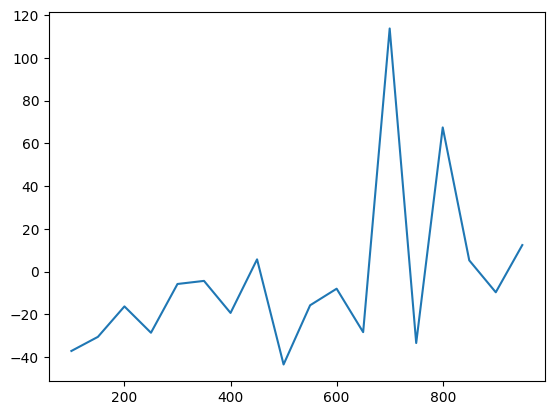

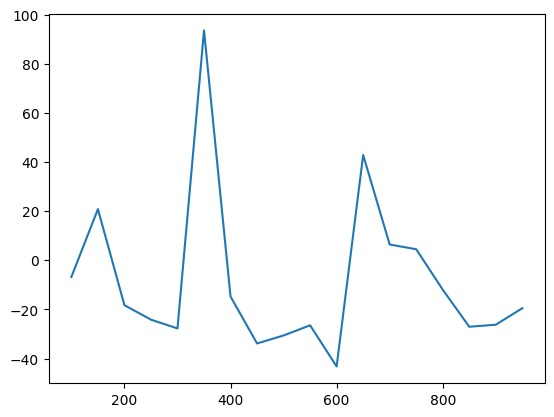

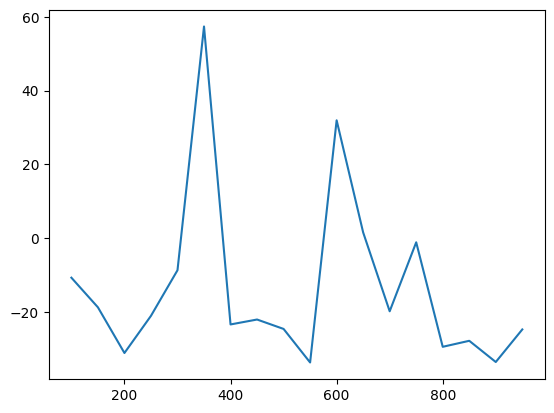

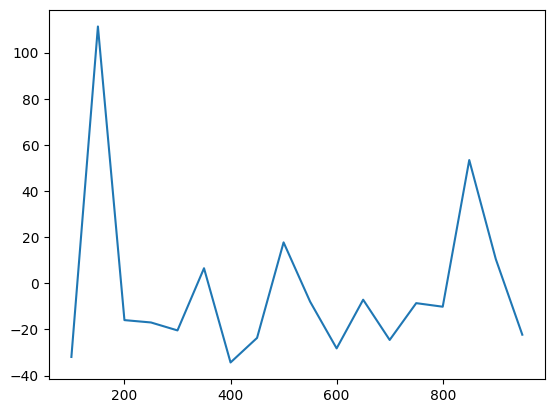

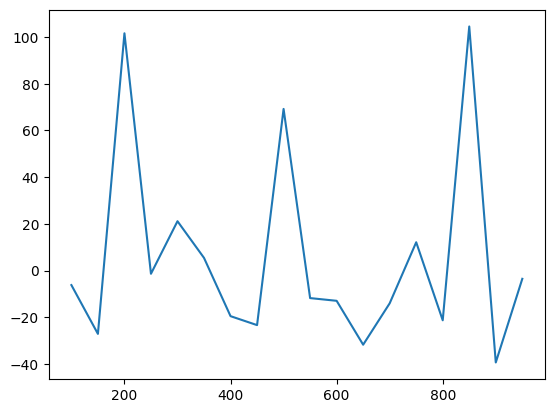

In [5]:
import matplotlib.pyplot as plt
import numpy as np

etiquetas = np.array(var_arr)
for topic in differences:
    valores = np.array(topic)

    plt.plot(etiquetas, valores)
    plt.show()